## Imports

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Load images and masks

In [2]:
images_path = '/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/Lady/patches'
masks_path = '/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/Lady/masks'
images_name = os.listdir(images_path)

# Load images and masks
images = []
masks = []
for image_name in images_name[:100]:
    image = cv2.imread(os.path.join(images_path, image_name))
    mask = cv2.imread(os.path.join(masks_path, image_name))
    images.append(image)
    masks.append(mask)

# mask: channel 0 is background, channel 1 is for glands, channel 2 is for nuclei

## Plot mask over image

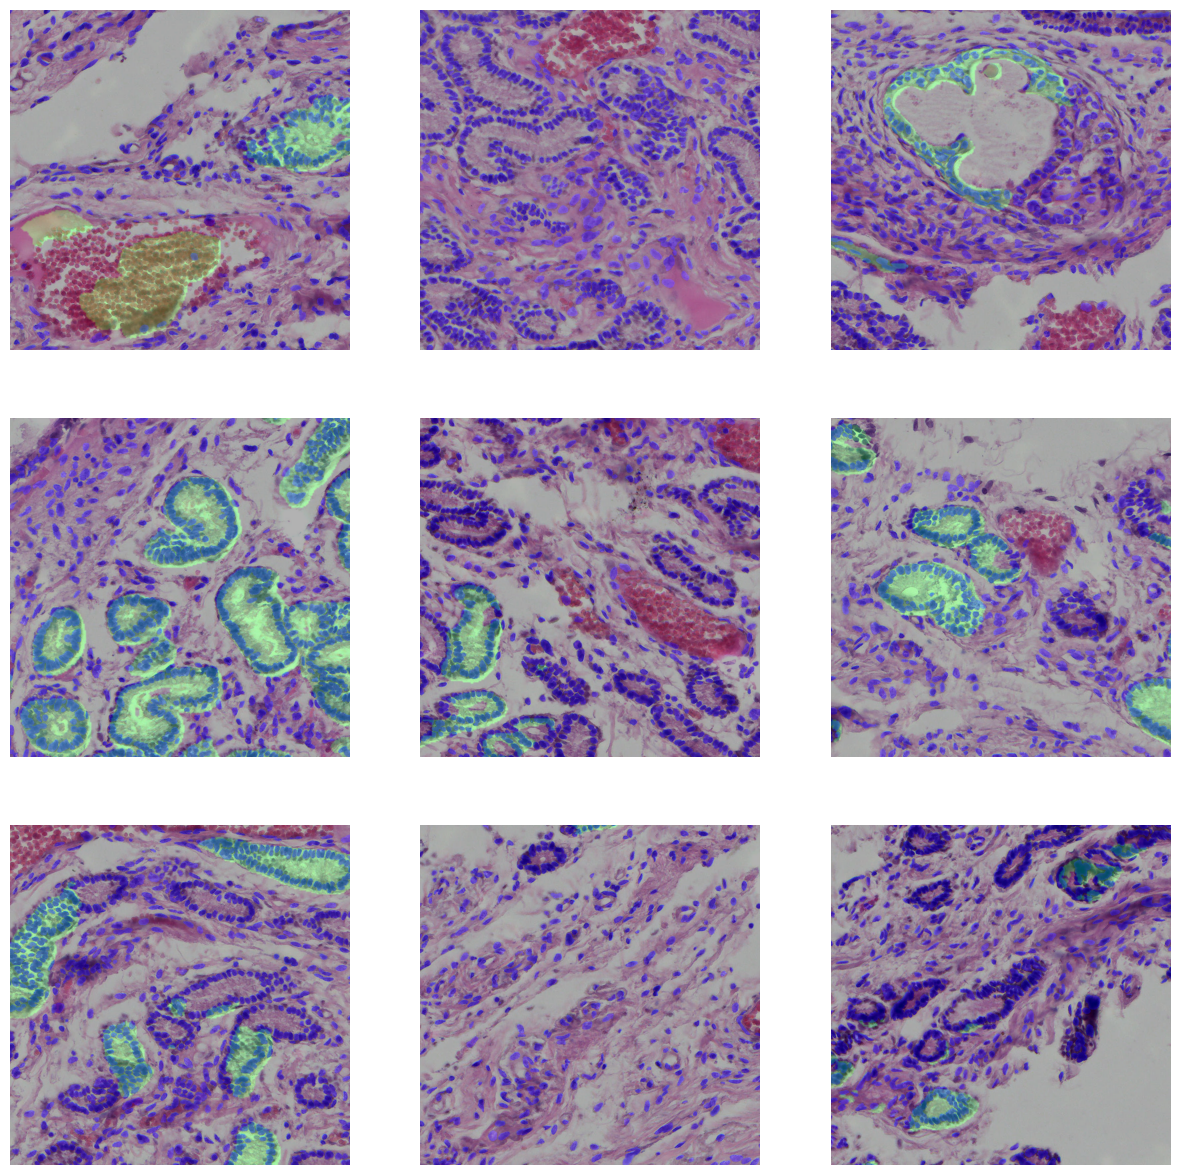

In [3]:
fig = plt.figure(figsize=(15,15))
random_images = np.random.randint(0,len(images)-1,9)

for i in range(len(random_images)):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(cv2.addWeighted(cv2.cvtColor(images[random_images[i]], cv2.COLOR_BGR2RGB),0.7,masks[random_images[i]],0.3,0))
    plt.axis('off')

## Further processing

Obtain nuclei masks without nuclei inside glands.  
Dilation of the nuclei left.  
Separate nuclei instances with opencv connectedComponentsWithStats and obtain the area of each instance.  
Get the instances with area greater than 3500. The threshold was selected based on test images.   
The threshold could not depend on the image because in case the image had no glands in it, if a threshold value of mean area + 1.5 * standard_deviation was set, that value would have been really low and some separate nuclei would be selected.


In [4]:
kernel = np.ones((3, 3), np.uint8)
added_masks = []

"""
cv2.connectedComponentsWithStats outputs:
    num_labels: The total number of labels [0, ..., N-1] where 0 represents the background label.
    nuceli_instances: A grayscale image where each pixel is the label of the object at that location.
    stats: A 2D array where each row is a 5-dim vector that contains the following information, in order:
        CC_STAT_LEFT: The leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
        CC_STAT_TOP: The topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
        CC_STAT_WIDTH: The horizontal size of the bounding box.
        CC_STAT_HEIGHT: The vertical size of the bounding box.
        CC_STAT_AREA: The total area (in pixels) of the connected component.
    centroids: A 2D array where each row indicates the (x, y) coordinate of a centroid. The row corresponds to the label number. 
"""

for i in range(len(masks)):
    mask_filtered = masks[i].copy()
    mask_filtered[mask_filtered[:,:,1] == 255,2] = 0
    img_dilation = cv2.dilate(mask_filtered[:,:,2], kernel, iterations=3)
    num_labels, nuclei_instances, stats, centroids = cv2.connectedComponentsWithStats(img_dilation)
    glands = np.where(stats[:,4]>=3500)
    mask_dilated = np.zeros((mask_filtered.shape[0], mask_filtered.shape[1],3), dtype=np.uint8)
    for j in range(1,len(glands[0])):
        mask_dilated[np.where(nuclei_instances == glands[0][j])] = [0,255,0]
    added_mask = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)
    added_mask[:,:,1] = masks[i][:,:,1]
    added_mask[mask_dilated[:,:,1]==255,1] = 255
    added_masks.append(added_mask)

## Add gland mask with filtered dilatated nuclei mask, and plot over image

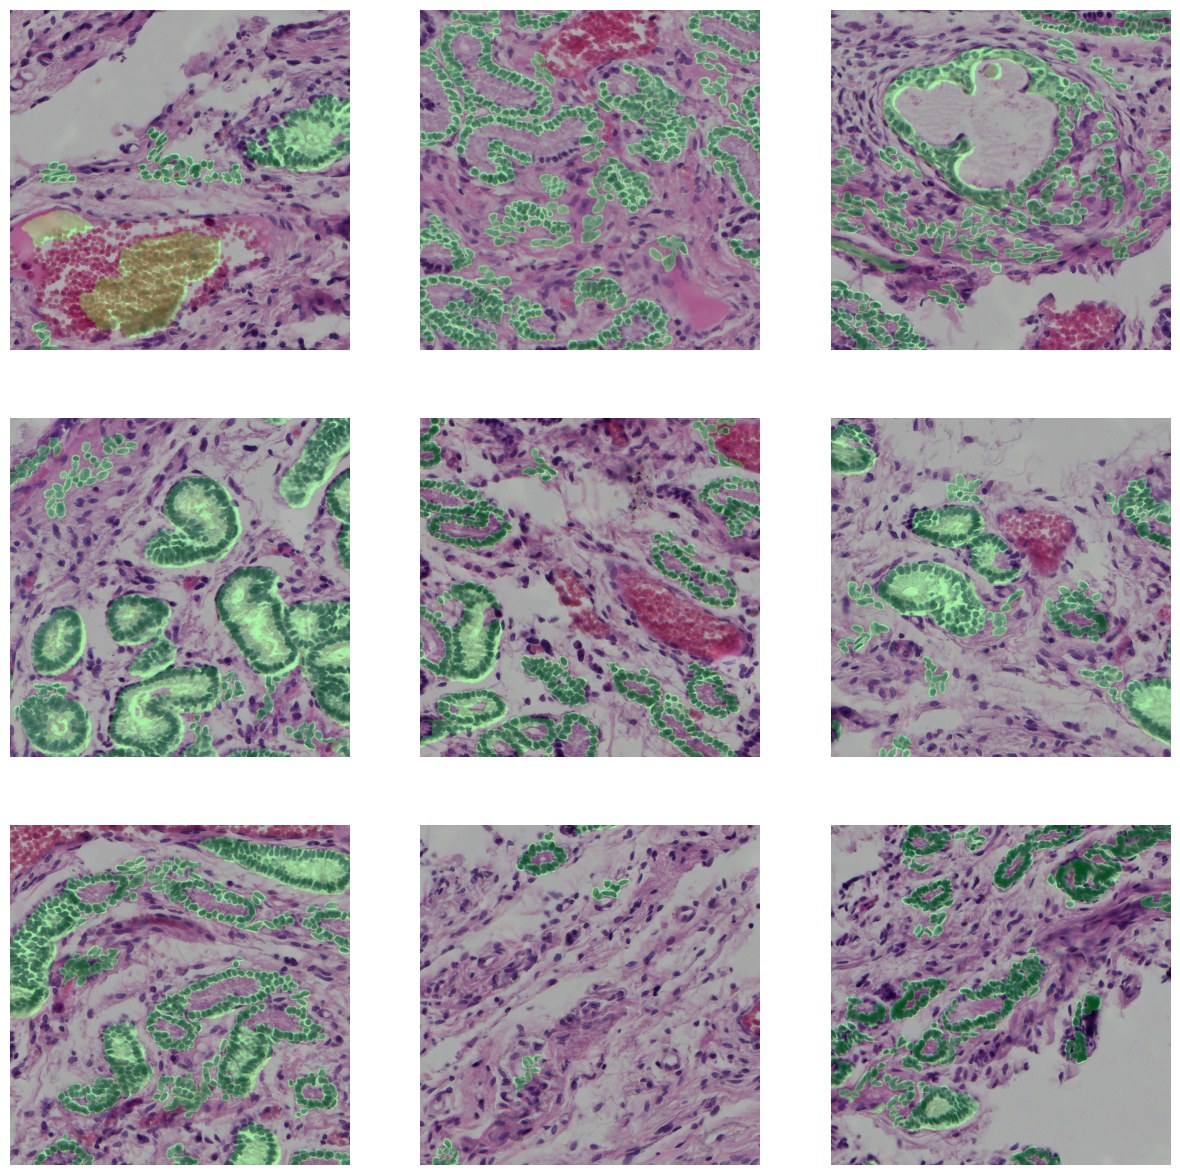

In [5]:
fig = plt.figure(figsize=(15,15))

for i in range(len(random_images)):
    fig.add_subplot(3, 3, i+1)
    plt.imshow(cv2.addWeighted(cv2.cvtColor(images[random_images[i]], cv2.COLOR_BGR2RGB),0.7,added_masks[random_images[i]],0.3,0))
    plt.axis('off')

## Get the nuclei masks without nuclei inside glands

In [6]:
masks_filtered_path = '/home/sofia/Documents/FING/Proyecto/clasificacion_de_nucleos/Lady/masks_filtered'
masks_filtered = []

for i in range(len(masks)):
    mask_filtered = masks[i][:,:,2].copy()
    mask_filtered[added_masks[i][:,:,1] == 255] = 0
    masks_filtered.append(mask_filtered)
    cv2.imwrite(os.path.join(masks_filtered_path, images_name[i]), mask_filtered)

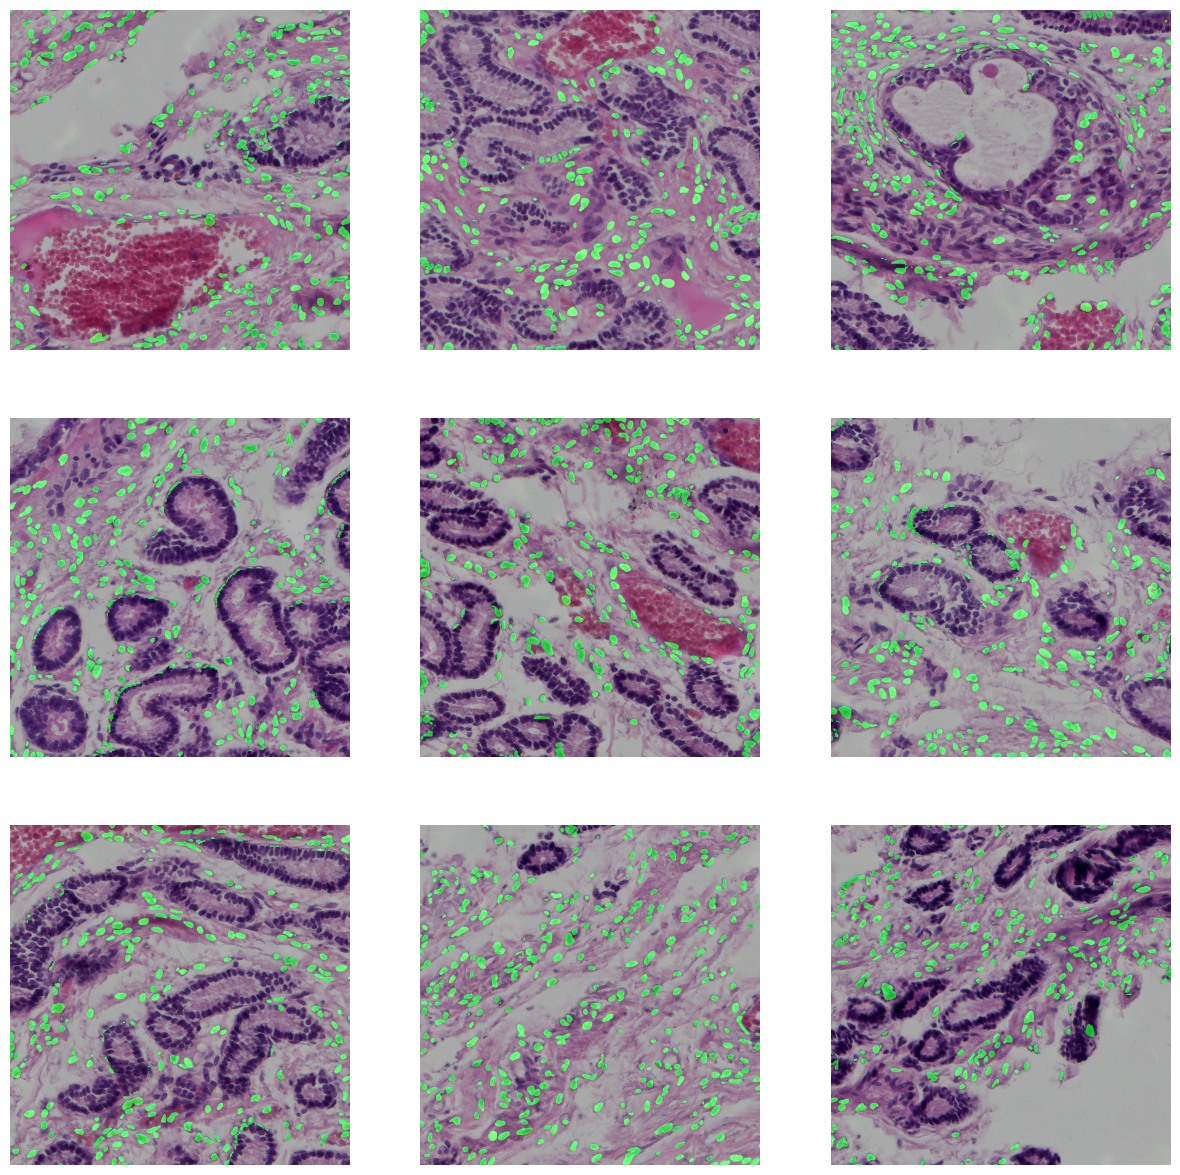

In [7]:
fig = plt.figure(figsize=(15,15))

for i in range(len(random_images)):
    fig.add_subplot(3, 3, i+1)
    mask_to_plot = np.zeros((masks_filtered[random_images[i]].shape[0], masks_filtered[random_images[i]].shape[1],3), dtype=np.uint8)
    mask_to_plot[:,:,1] = masks_filtered[random_images[i]]
    plt.imshow(cv2.addWeighted(cv2.cvtColor(images[random_images[i]], cv2.COLOR_BGR2RGB),0.7,mask_to_plot,0.7,0))
    plt.axis('off')